# Compare piano transcription methods

In [162]:
from src import utils
from src.detect.onset_utils import OnsetMaker, bandpass_filter
from src.detect.midi_utils import MIDIMaker
import librosa
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import src.visualise.visualise_utils as vutils

In [36]:
corp = utils.CorpusMaker.from_excel('corpus_updated', only_annotated=True, only_30_corpus=False)

## Current approach

In [92]:
loaded = utils.load_corpus_from_files(f'{utils.get_project_root()}/data/cambridge-jazz-trio-database-v02')
fns = set(track['fname'] for track in corp.tracks)
res_cur = [{'track': t.item['fname'], 'method': 'current', **t.item['validation']['piano']} for t in loaded if t.item['validation']['piano'] is not None and t.item['fname'] in fns]

## Automatic MIDI transcription

In [152]:
def auto_midi(item):
    mm = MIDIMaker(item)
    out = mm.convert_to_midi()
    ons = np.array(sorted(set(i['onset_time'] for i in out['est_note_events'])))
    to_keep = []
    seen = []
    for on in ons:
        diff = ons - on
        grouped = sorted([on, *ons[(diff <= 0.05) * (diff > 0)]])
        if not any(i in seen for i in grouped):
            to_keep.append(grouped[0])
        seen.extend(grouped[1:])
    fmt = np.array(sorted(set(to_keep)))
    made = OnsetMaker(item, skip_processing=False)
    return {
        'track': item['fname'],
        'method': 'automatic_midi', 
        **made.compare_onset_detection_accuracy(
            fname=rf'{made.references_dir}/manual_annotation/{item["fname"]}_piano.txt',
            onsets=fmt,
        )
    }

In [156]:
with Parallel(n_jobs=2, backend='loky', verbose=10) as par:
    res_mm = par(delayed(auto_midi)(i) for i in corp.tracks)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   50.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  4.0min
/home/hwc31/Cambridge-Jazz-Trio-Database/src/detect/detect_utils.py:185: UserWarning: item evansb-nocovernominimum-koticktmotianp-1956-f675dc4a, track bass exceeds silence threshold: (0.8 > 0.33)
  warnings.warn(
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  7.8min
/home/hwc31/Cambridge-Jazz-Trio-Database/src/detect/detect_utils.py:185: UserWarning: item powellb-sweetgeorgiabrown-russellcroachm-1950-25a7592c, track bass exceeds silence threshold: (0.9 > 0.33)
  warnings.warn(
[Parallel(n_jobs=2)]: Done  34 out of  34 | elapsed:  8.9min finished


In [157]:
res_mm

[{'track': 'tynerm-bluesforgwen-davisajonese-1962-72d0306f',
  'method': 'automatic_midi',
  'f_score': 0.948470883954755,
  'precision': 0.9180859691808597,
  'recall': 0.9809358752166378,
  'mean_asynchrony': -0.01229992192254986,
  'fraction_matched': 0.9809358752166378},
 {'track': 'tynerm-lildarlin-sharpeahayesl-1986-f892ef46',
  'method': 'automatic_midi',
  'f_score': 0.6038415366146458,
  'precision': 0.5883040935672514,
  'recall': 0.6202219482120839,
  'mean_asynchrony': -0.022365985956468094,
  'fraction_matched': 0.6202219482120839},
 {'track': 'tynerm-tranelike-clarkesfostera-1998-f61d311f',
  'method': 'automatic_midi',
  'f_score': 0.6392694063926941,
  'precision': 0.6094527363184079,
  'recall': 0.6721536351165981,
  'mean_asynchrony': -0.02088347940564255,
  'fraction_matched': 0.6721536351165981},
 {'track': 'barronk-somedaymyprincewillcome-williamsbrileyb-1982-709cf40e',
  'method': 'automatic_midi',
  'f_score': 0.599135861737878,
  'precision': 0.5740570377184913,

## Spectral flux

In [20]:
# Set the optimised defaults
params_sf = {
    "wait": 18,
    "delta": 0.023021937161684,
    "pre_max": 20,
    "post_max": 22,
    "pre_avg": 53,
    "post_avg": 4
}

In [66]:
def spec_flux(item):
    made = OnsetMaker(item, skip_processing=False)
    ons = librosa.onset.onset_detect(
        y=made.audio['piano'],
        sr=utils.SAMPLE_RATE,
        hop_length=utils.HOP_LENGTH,
        units='time',
        **params_sf
    )  
    return {
        'track': item['fname'],
        'method': 'spectral_flux', 
        **made.compare_onset_detection_accuracy(
            fname=rf'{made.references_dir}/manual_annotation/{item["fname"]}_piano.txt',
            onsets=ons,
        )
    }

In [75]:
with Parallel(n_jobs=-1, backend='loky', verbose=10) as par:
    res_sf = par(delayed(spec_flux)(i) for i in corp.tracks)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  34 | elapsed:   13.3s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   7 out of  34 | elapsed:   28.8s remaining:  1.8min
/home/hwc31/Cambridge-Jazz-Trio-Database/src/detect/detect_utils.py:185: UserWarning: item evansb-nocovernominimum-koticktmotianp-1956-f675dc4a, track bass exceeds silence threshold: (0.8 > 0.33)
  warnings.warn(
/home/hwc31/Cambridge-Jazz-Trio-Database/src/detect/detect_utils.py:185: UserWarning: item powellb-sweetgeorgiabrown-russellcroachm-1950-25a7592c, track bass exceeds silence threshold: (0.9 > 0.33)
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  11 out of  34 | elapsed:   47.9s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  15 out of  34 | elapsed:   52.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  19 out of  34 | elapsed:   59.4s remaining:   46.9s
[Parallel(n_jobs=-1)]: Done  23 out of  34 | elapsed:  1.0min remaining:   29.2s
[Parallel

## Current approach, no filtering

In [77]:
def no_filter(item):
    made = OnsetMaker(item, skip_processing=True)
    fname = made._get_channel_override_fpath('piano', made.instrs['piano'])
    made.audio = {}
    y, _ = librosa.load(
        path=fname,
        sr=utils.SAMPLE_RATE,
        mono=True,
        offset=0,
        duration=None,
        dtype=np.float64,
        res_type='soxr_vhq',
    )
    made.audio['piano'] = librosa.util.normalize(y)
    ons = made.onset_detect_cnn('piano')
    return {
        'track': item['fname'],
        'method': 'cnn_no_filter', 
        **made.compare_onset_detection_accuracy(
            fname=rf'{made.references_dir}/manual_annotation/{item["fname"]}_piano.txt',
            onsets=ons,
        )
    }

In [78]:
with Parallel(n_jobs=-1, backend='loky', verbose=10) as par:
    res_nf = par(delayed(no_filter)(i) for i in corp.tracks)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  34 | elapsed:    3.0s remaining:   30.7s
[Parallel(n_jobs=-1)]: Done   7 out of  34 | elapsed:    4.6s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  11 out of  34 | elapsed:    7.3s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  15 out of  34 | elapsed:    8.2s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  19 out of  34 | elapsed:   10.1s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  23 out of  34 | elapsed:   11.2s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  27 out of  34 | elapsed:   11.4s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  31 out of  34 | elapsed:   12.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   14.0s finished


## Current approach, more filter

In [102]:
def more_filter(item, lowcut, highcut):
    made = OnsetMaker(item, skip_processing=True)
    fname = made._get_channel_override_fpath('piano', made.instrs['piano'])
    made.audio = {}
    y, _ = librosa.load(
        path=fname,
        sr=utils.SAMPLE_RATE,
        mono=True,
        offset=0,
        duration=None,
        dtype=np.float64,
        res_type='soxr_vhq',
    )
    y = bandpass_filter(
        audio=y,
        lowcut=lowcut,
        highcut=highcut,
        order=made.order
    )
    made.audio['piano'] = librosa.util.normalize(y)
    ons = made.onset_detect_cnn('piano')
    return {
        'track': item['fname'],
        'method': f'cnn_{lowcut}_{highcut}', 
        **made.compare_onset_detection_accuracy(
            fname=rf'{made.references_dir}/manual_annotation/{item["fname"]}_piano.txt',
            onsets=ons,
        )
    }

In [103]:
with Parallel(n_jobs=-1, backend='loky', verbose=10) as par:
    res_220_1760 = par(delayed(more_filter)(i, 220, 1760) for i in corp.tracks)
    res_27_4186 = par(delayed(more_filter)(i, 27.5, 4186) for i in corp.tracks)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  34 | elapsed:    2.9s remaining:   29.5s
[Parallel(n_jobs=-1)]: Done   7 out of  34 | elapsed:    6.0s remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  11 out of  34 | elapsed:    8.7s remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  15 out of  34 | elapsed:    9.3s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  19 out of  34 | elapsed:   12.1s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  23 out of  34 | elapsed:   12.7s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  27 out of  34 | elapsed:   13.7s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  31 out of  34 | elapsed:   14.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  34 | elapsed:    3.7s remaining:   38.5s
[Parallel(n_jobs=-1)]: Done   7 out of  34 | e

## Putting it all together

In [158]:
df = pd.DataFrame(res_cur + res_sf + res_nf + res_220_1760 + res_27_4186 + res_mm)

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

In [180]:
class BarPlotPianoMethodsComparison(vutils.BasePlot):
    """Creates bar plot showing duration of recordings by each bandleader"""
    BAR_KWS = dict(
        stacked=True, color=[vutils.RED, vutils.GREEN],
        zorder=10, lw=vutils.LINEWIDTH, edgecolor=vutils.BLACK,
    )

    def __init__(self, corp_df, **kwargs):
        self.corpus_title = 'corpus_updated'
        fig_title = fr'corpus_plots\barplot_corpusduration_{self.corpus_title}'
        # Initialise the base plot with our given kwargs
        super().__init__(figure_title=fig_title, **kwargs)
        self.df = self._format_df(corp_df.copy(deep=True))
        self.fig, self.ax = plt.subplots(1, 1, figsize=(vutils.WIDTH, vutils.WIDTH / 2))

    @staticmethod
    def _format_df(corp_df: pd.DataFrame) -> pd.DataFrame:
        """Coerces corpus into correct format for plotting"""
        sorter = corp_df.groupby('method')['f_score'].mean().sort_values().index
        sorterIndex = dict(zip(sorter, range(len(sorter))))
        corp_df['sorter'] = corp_df['method'].map(sorterIndex)
        return corp_df.sort_values(by='sorter', ascending=False).reset_index(drop=True)

    def _create_plot(self) -> plt.Axes:
        """Creates main plot object"""
        return sns.barplot(
            data=self.df, x='method', y='f_score', ax=self.ax
        )

    def _format_ax(self) -> None:
        """Set axis-level parameters"""
        self.ax.grid(axis='y', which='major', **vutils.GRID_KWS)
        self.ax.tick_params(axis='y', which='both', pad=65)
        self.ax.tick_params(axis='both', width=vutils.TICKWIDTH)
        plt.setp(self.ax.spines.values(), linewidth=vutils.LINEWIDTH)

    def _format_fig(self) -> None:
        """Set figure-level parameters"""
        self.fig.subplots_adjust(top=0.95, bottom=0.1, left=0.2, right=0.95)

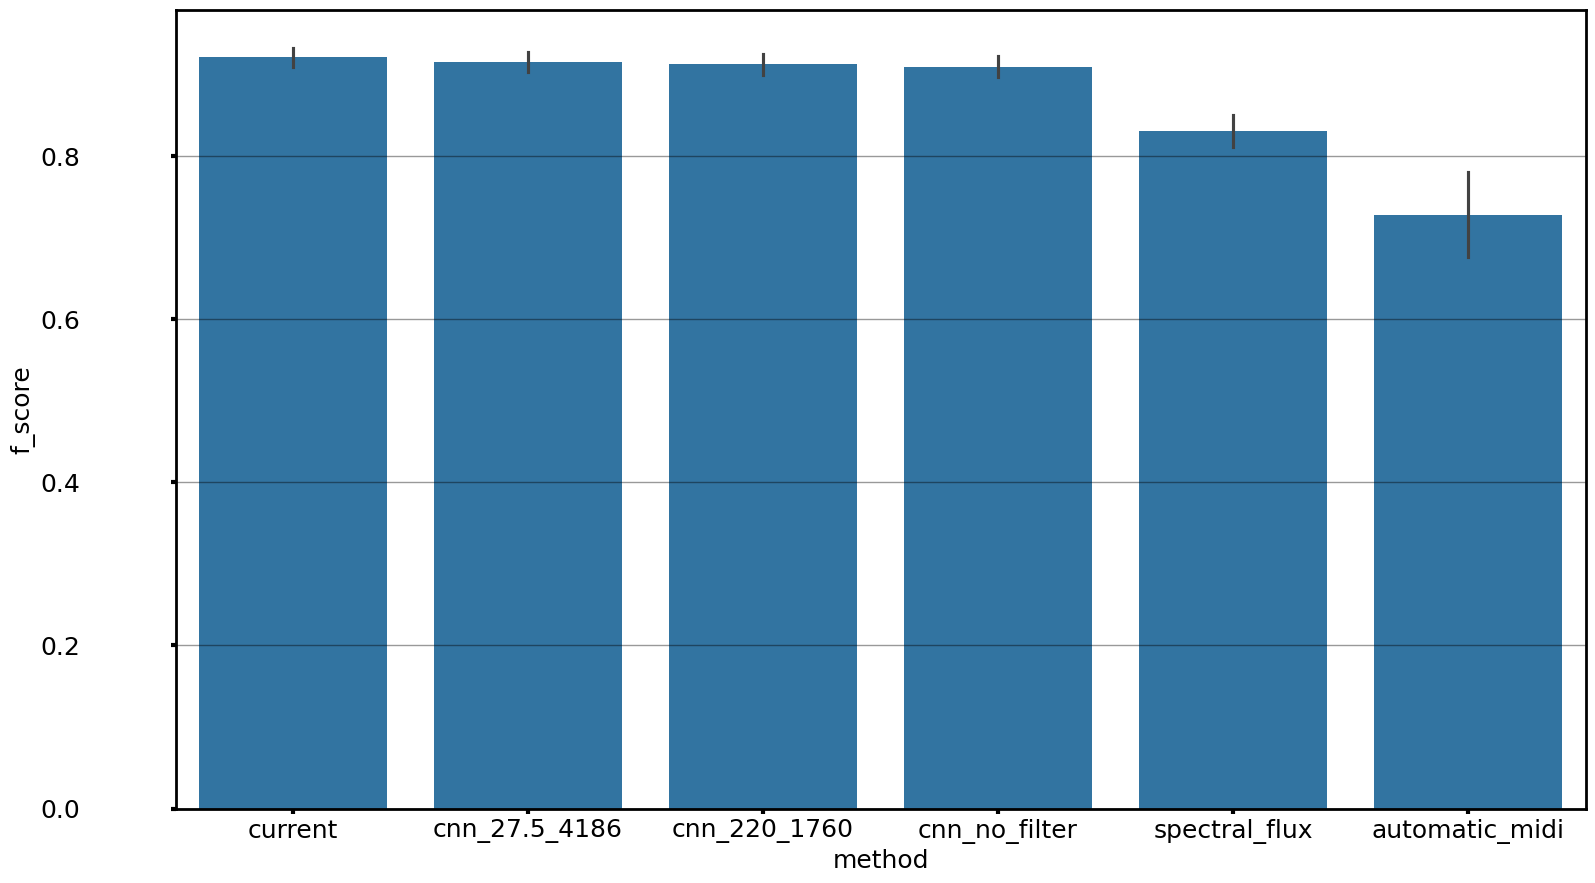

In [181]:
BarPlotPianoMethodsComparison(df).create_plot()
plt.show()

In [182]:
print(corp)

                                 track_name  \
0                            Blues for Gwen   
1                                Lil Darlin   
2                                 TraneLike   
3               Someday My Prince Will Come   
4                         Take the Coltrane   
5                              Shuffle Boil   
6                              Just Friends   
7                              Denzils Best   
8                                  Birdsong   
9                          Ralphs New Blues   
10                                Holy Mama   
11                                 Broadway   
12   Spring Will Be a Little Late This Year   
13                            Dolphin Dance   
14                                    Milan   
15                      No Cover No Minimum   
16          Glorias Step take 1 interrupted   
17                      Glorias Step take 3   
18                                    Emily   
19                                   SeeSaw   
20           